# Exoplanet Transit of TOI 1292

In [29]:
from pytransit import TransitAnalysis
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import astropy.units as u
import astropy.constants as c
from corner import corner

In [2]:
# Getting the data
toi1292 = pd.read_csv('data/TOI1292_full.dat', sep='\t', header=1, usecols=[2,3,4], names=['time', 'flux', 'err'])

# Get data within the transit
toi1292 = toi1292[toi1292['time'] > 2460114.78]

# Normalizing the data by the stellar flux

# Getting stellar indices before and after the transit
stellar_ind = (toi1292['time'] < 2460114.80) | (toi1292['time'] > 2460114.825) # the character "|" means "or"

toi1292['flux'] = toi1292['flux'] / np.median(toi1292['flux'][stellar_ind])
toi1292['err'] = toi1292['err'] / np.median(toi1292['flux'][stellar_ind])


Text(0.5, 1.0, 'TOI 1292 Transit Photometry')

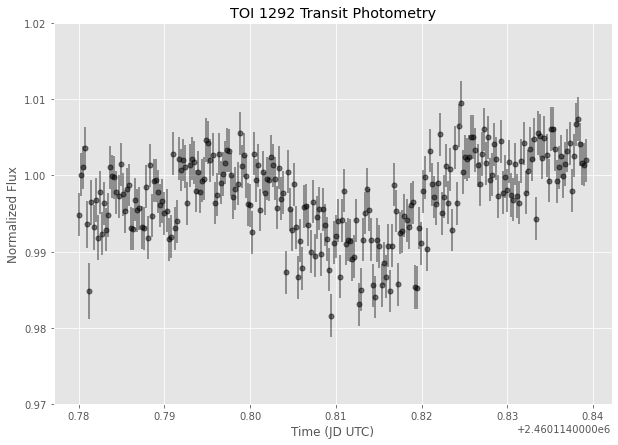

In [3]:
# Plotting the data
plt.style.use('ggplot')
plt.figure(figsize=(10, 7))

plt.errorbar(toi1292['time'], toi1292['flux'], toi1292['err'], ms=5, \
            marker="o", ls="none", label="Data", color="black", alpha=0.5)

plt.ylim(0.97,1.02)
plt.ylabel("Normalized Flux")
plt.xlabel("Time (JD UTC)")
plt.title('TOI 1292 Transit Photometry')

In [4]:
# Creating the PyTransit TransitAnalysis object
# 'name' is the name of the object (arbitrary)
# 'passbands' is the passband of the data (arbitrary)
# 'times' is the time array of the data
# 'fluxes' is the flux array of the data
ta = TransitAnalysis(name='TOI1292', passbands='32inch', times=toi1292['time'].to_numpy(), fluxes=toi1292['flux'].to_numpy())#, errors=toi1292['err'].to_numpy())
ta.print_parameters(1)

  0 |G| rho            U(a = 0.1, b = 25.0)                     [    0.00 ..      inf]
  1 |G| tc_1           N(μ = 0.0, σ = 0.1)                      [    -inf ..      inf]
  2 |G| p_1            N(μ = 1.0, σ = 1e-05)                    [    0.00 ..      inf]
  3 |G| b_1            U(a = 0.0, b = 1.0)                      [    0.00 ..      inf]
  4 |G| k2_1           U(a = 0.0004, b = 0.04000000000000001)   [    0.00 ..      inf]
  5 |G| secw_1         N(μ = 0.0, σ = 1e-05)                    [   -1.00 ..     1.00]
  6 |G| sesw_1         N(μ = 0.0, σ = 1e-05)                    [   -1.00 ..     1.00]
  7 |P| q1_32inch      U(a = 0, b = 1)                          [    0.00 ..     1.00]
  8 |P| q2_32inch      U(a = 0, b = 1)                          [    0.00 ..     1.00]
  9 |L| wn_loge_0      U(a = -4, b = 0)                         [    -inf ..      inf]


Global optimisation:   0%|          | 0/500 [00:00<?, ?it/s]

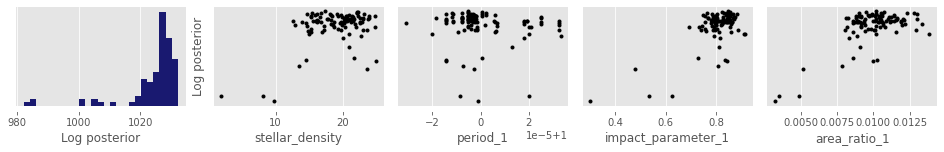

In [5]:
# Conducts an initial fit
ta.optimize_global(niter=500, npop=100)

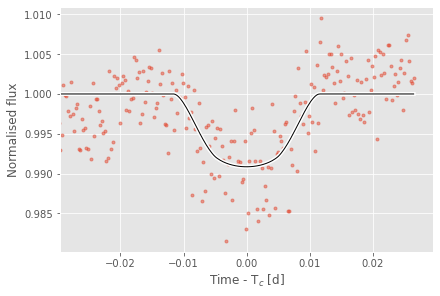

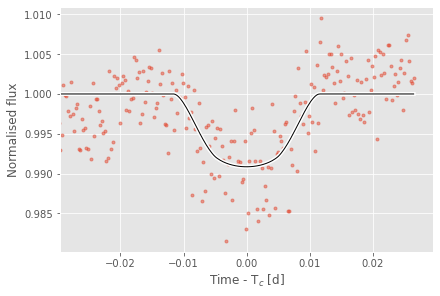

In [6]:
# Plotting the fit results
ta.plot_light_curves(method='fit')

In [7]:
# Conducting a Markov Chain Monte Carlo (MCMC) fit to get the posterior distributions of the parameters
ta.sample_mcmc(niter=10000, thin=100, repeats=3, save=False)

MCMC sampling:   0%|          | 0/3 [00:00<?, ?it/s]

Run 1/3:   0%|          | 0/10000 [00:00<?, ?it/s]

Run 2/3:   0%|          | 0/10000 [00:00<?, ?it/s]

Run 3/3:   0%|          | 0/10000 [00:00<?, ?it/s]

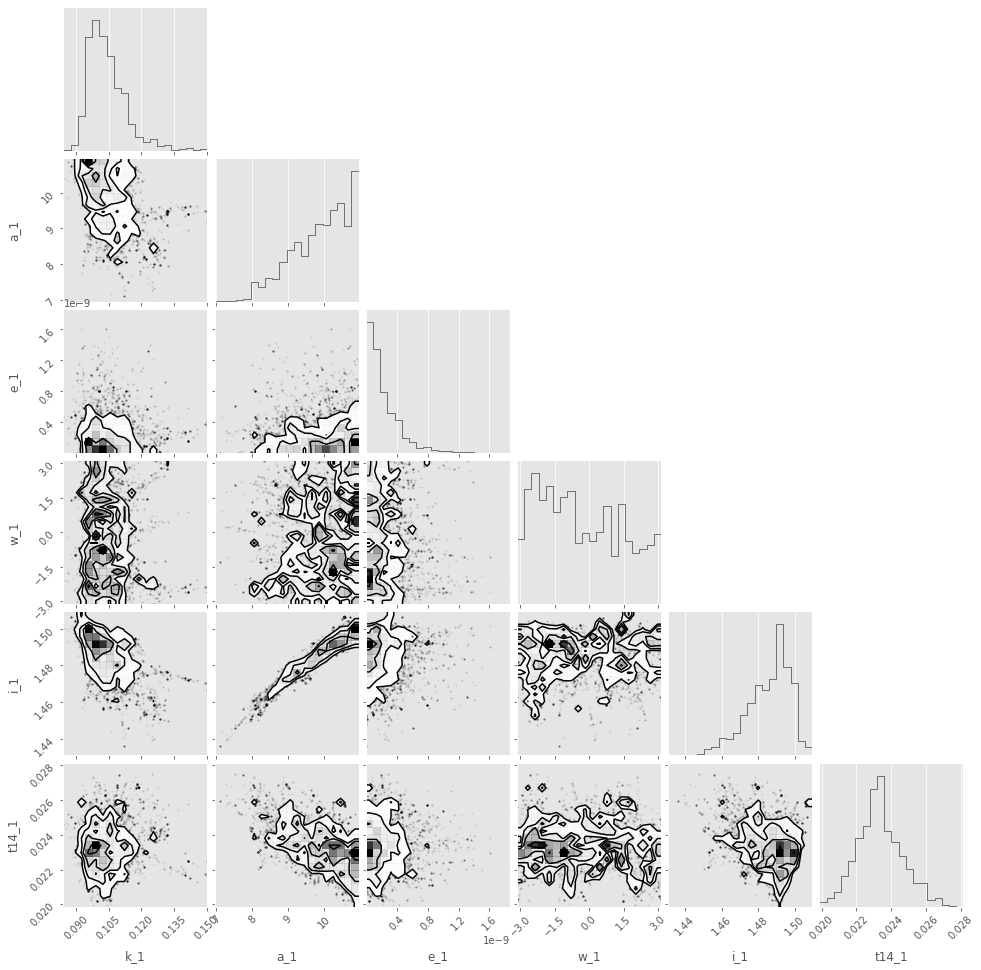

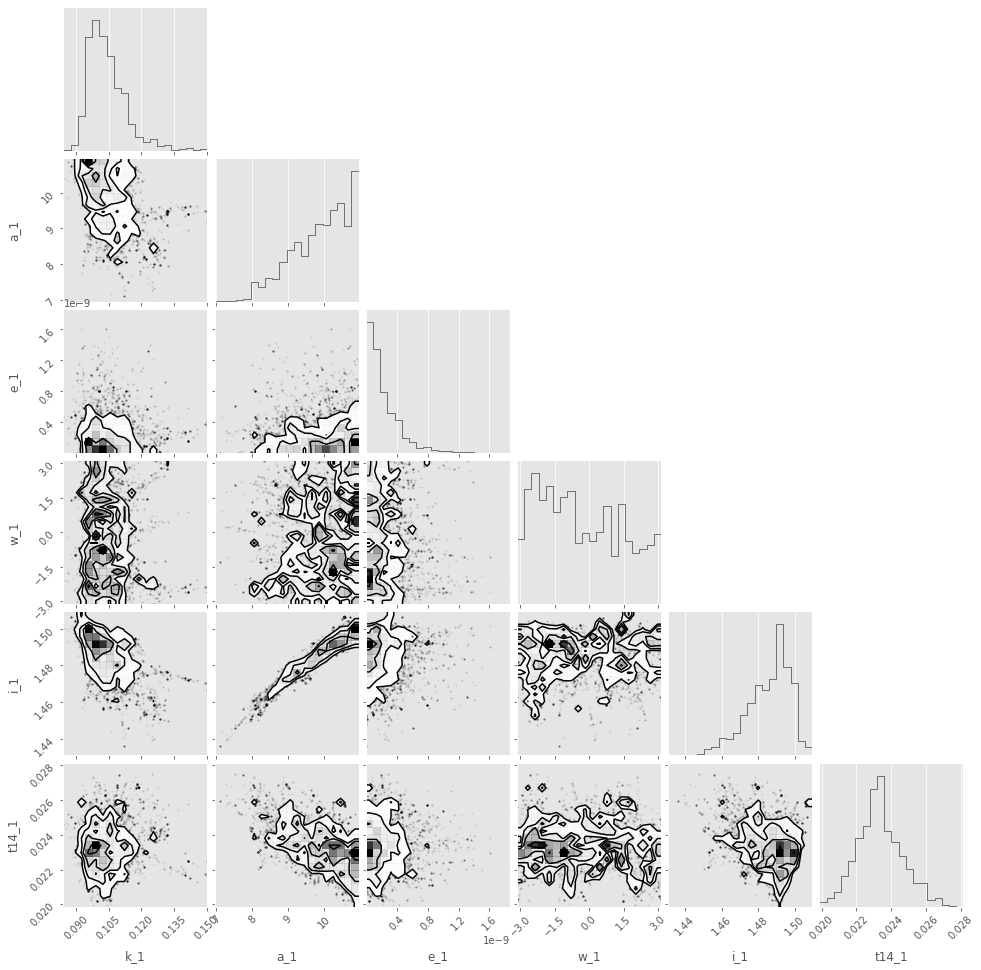

In [9]:
# Getting corner plots
samples = ta.posterior_samples()

# Plotting the corner plots
corner(samples.derived_parameters[['k_1', 'a_1', 'e_1', 'w_1', 'i_1', 't14_1']])

In [10]:
# Getting the posterior samples
pvp = ta.posterior_samples().posterior.to_array().values.copy().T.reshape([-1, len(ta.ps)])

# Getting the posterior samples of the flux model
fmodel = ta.flux_model(np.random.permutation(pvp))

/Users/shockblack/opt/anaconda3/lib/python3.9/site-packages/arviz/data/inference_data.py:1361: UserWarning: The group derived_parameters is not defined in the InferenceData scheme
  warnings.warn(


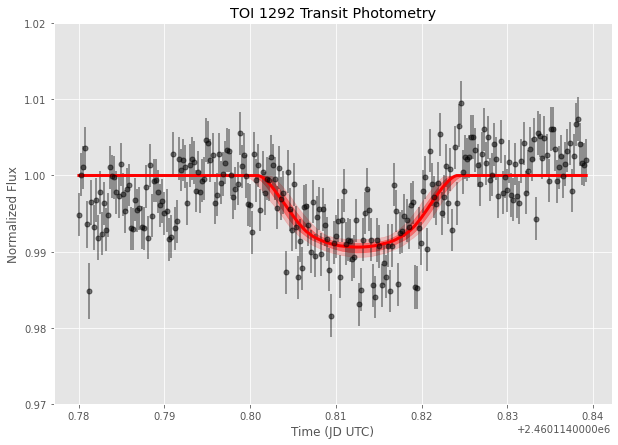

In [28]:
# Getting the times and quantiles
times = ta.times[0]
fmperc = np.percentile(fmodel, [2.5, 16, 50, 84, 97.5], 0)


# Plotting the data
plt.style.use('ggplot')
plt.figure(figsize=(10, 7))

# Plotting the data
plt.errorbar(toi1292['time'], toi1292['flux'], toi1292['err'], ms=5, \
            marker="o", ls="none", label="Data", color="black", alpha=0.5)

plt.ylim(0.97,1.02)
plt.ylabel("Normalized Flux")
plt.xlabel("Time (JD UTC)")
plt.title('TOI 1292 Transit Photometry')

# Best fit model (median)
plt.plot(times, fmperc[2], alpha=1, color='r', lw=3)

# Plotting the quantiles
plt.fill_between(times, fmperc[0], fmperc[4], alpha=0.2, color='r')
plt.fill_between(times, fmperc[1], fmperc[3], alpha=0.4, color='r')

In [42]:
# Stellar parameters given from Tess catalog (Stassun et al. 2019)

# Stellar radius
r_star = 1.4605600 * u.Rsun

# Radius of planet given by best fit ratio

# Median of the posterior samples for the radius ratio
radius_ratio = samples.derived_parameters['k_1'].median().data

r_planet = r_star * radius_ratio

r_planet = r_planet.to(u.Rjup)

print('Radius of planet: ', r_planet)

Radius of planet:  1.4535718613658686 jupiterRad
